Table of Contents
==
1: [Storing Tasks](#toc_1)
1.1: [Save tweets from twitter to MongoDB](#toc_1.1)
1.2: [Copy chunked tweets from HW 2 to MongoDB](#toc_1.2)
2: [Retrieving and Analyzing Tasks](#toc_2)
2.1: [Top Retweets](#toc_2.1)
2.2: [Lexical Diversity](#toc_2.2)
2.3: [Track unfollows](#toc_2.3)
2.4: [Sentiment analysis](#toc_2.4)
3: [Storing and Retrieving Task](#toc_3)
3.1: [Backup & Restore](#toc_3.1)


<a name='toc_1'></a>1: Storing Tasks
==
<a name='toc_1.1'></a>1.1: Save tweets from twitter to MongoDB
--
Write a python program to automatically retrieve and store the JSON files (associated with the tweets that include #NBAFinals2015 hashtag and the tweets that include #Warriors hashtag) returned by the twitter REST api in a MongoDB database called db_restT. 

<a name='toc_1.2'></a>1.2: Copy chunked tweets from HW 2 to MongoDB
--
Write a python program to automatically retrieve and store the JSON files (associated with the tweets that include #NBAFinals2015 hashtag and the tweets that include #Warriors hashtag) returned by the twitter REST api in a MongoDB database called db_restT. 

These are in files [1.1_acq.py](1.1_acq.py) and [1.2_s3tomongo.py](1.2_s3tomongo.py).

The first uses much of the code from Assignment 2, with the addition of a `MongoDBSink` in `sinks.py` to store tweets to a specified database and collection.

The second simply reads the files from S3 to a string, uses `json.loads` to read the contents into an array, and writes the tweets with `insert_many`.

<a name='toc_2'></a>2: Retrieving and Analyzing Tasks
==================

In [2]:
%matplotlib inline

In [53]:
from __future__ import print_function
import matplotlib
matplotlib.style.use('ggplot')
from  pandas import DataFrame
from pprint import pprint
import pymongo
import re
from collections import namedtuple
from  nltk.tokenize import word_tokenize
import tweepy
import os, os.path
import datetime
from credentials import Credentials

In [4]:
dbclient = pymongo.MongoClient()

In [5]:
creds = Credentials(os.path.expanduser('~/.tweepy'))
auth = tweepy.AppAuthHandler(creds.consumer_key, creds.consumer_secret)
api = tweepy.API(auth_handler=auth,
                  compression=True,
                  retry_errors=set((104,)),
                  retry_count=100,
                  timeout=3600,
                  wait_on_rate_limit=True,
                  wait_on_rate_limit_notify=True)

<a name='toc_2.1'></a>2.1: Top Retweets
---
Analyze the tweets stored in db_tweets by finding the top 30 retweets as well as their associated usernames (users authored them) and the locations of users.

Creating an index on retweeted_status.id will let us avoid both a collection scan and a sort when grouping retweets by id.

In [46]:
dbclient.db_tweets.tweets.create_index('retweeted_status.id')

u'retweeted_status.id_1'

Next, we set up a pymongo agg pipeline to get the top 30 retweets
Since we need to count occurences, this requires an index scan.
Instead of processing the results immediately, we save the result to another collection for subsequent, possibly repeated, analysis.
The pattern I adopt here is that the code block that creates a table also drops/indexes it, for modularity.

In [47]:
dbclient.db_tweets.drop_collection('top_retweets')
cursor=dbclient.db_tweets.tweets.aggregate([
        {'$match': {'retweeted_status.id' : { '$exists': True }}},
        {'$group': {'_id': '$retweeted_status.id',
                    'count': {'$sum': 1 },
                    'user': {'$first': '$retweeted_status.user' },
                    'text': {'$first': '$retweeted_status.text' }}},
        {'$sort': {'count': -1 }},
        {'$limit': 30 },
        {'$out': 'top_retweets'}
        ])
dbclient.db_tweets.top_retweets.create_index('count')

u'count_1'

We process the results of the aggregation pipeline by printing each result and adding each user ID to a set of most RTed users

In [19]:
most_rt_users=set()
cursor=dbclient.db_tweets.top_retweets.find({},sort=[('count', -1)])
for (count, row) in enumerate(cursor):
    user=row['user']
    most_rt_users.add(user['id'])
    print(u'#{0}: {1} from {2} retweeted {3} times\n{4}'.format(
            count+1,
            user['screen_name'],
            user['location'],
            row['count'],
            row['text']))

#1: warriors from Oakland, CA retweeted 40727 times
The wait is over – Your Golden State #Warriors are #NBA CHAMPIONS!!! #GSW #NBAFinals http://t.co/3xxxrnJbJN
#2: warriors from Oakland, CA retweeted 6363 times
The #Warriors have won their first NBA Championship in 40 years after defeating the Cavs 105-97 in Game 6. http://t.co/kLe2TzALQu
#3: StephenCurry30 from Worldwide retweeted 2513 times
Dubnation!!!!!!!! Thank you for today. Will remember it for the rest of my life! #oakland #warriors… https://t.co/zFE4GbDWD2
#4: warriors from Oakland, CA retweeted 2383 times
#Warriors close 1Q out on 8-0 run to take a 13-point lead into the startof 2Q. #StrengthInNumbers #GSW #NBAFinals http://t.co/0fKJzzwiHa
#5: warriors from Oakland, CA retweeted 1675 times
The #Warriors are set to face the Cavaliers in Game 6 of the #NBAFinals on Tuesday night in Cleveland.
https://t.co/bu12LnXfGR
#6: warriors from Oakland, CA retweeted 1434 times
. @cavs answer back in 2Q &amp; what was a 13-point #Warriors 

<a name='toc_2.2'></a>2.2: Lexical Diversity
---
Compute the lexical diversity of the texts of the tweets for each of the users in db_restT and store the results back to Mongodb. To compute the lexical diversity of a user, you need to find all the tweets of a particular user (a user's tweets corpus), find the number of unique words in the user's tweets corpus, and divide that number by the total number of words in the user's tweets corpus.

You need to create a collection with appropriate structure for storing the results of your analysis.

This is the first time we're looking at db_restT, so we start by indexing the tweet collection by user ID for subsequent aggregation on that field.

In [39]:
dbclient.db_restT.tweets.create_index('user.id')

u'user.id_1'

In [ ]:
# make a table of db_restT unique users
dbclient.db_restT.drop_collection('users')
dbclient.db_restT.tweets.aggregate([
        {'$group': {'_id': '$user.id',
                    'name': {'$first': '$user.screen_name'}}},
        {'$out': 'users'}
    ])

First, fetch each user's tweets and store them into `db_restT.user_tweets`, omitting RTs since they are not the user's text.
Storing them permits comparison of different tokenizing methods and avoids the need to restart in case of failure.

The `user_timeline` API per-call count limit is 200 statuses, and the call cannot retrieve more than 3200 tweets total. Limiting to 1000 tweets should be enough to be a representative sample, while eliminating 2/3 of the 15 minute rate limit delays.  The acquisition time can be further reduced by limiting the number of users (to 1000 of 6542) for whom we analyze statuses.

(*Note*: I got impatient and interrupted the kernel after 870 users.)

Some notes on implementation:
* it is necessary to retrieve the user IDs from mongodb prior to the loop on `user_timeline` calls.  Otherwise the mongodb cursor in the outer loop will become invalue due to twitter rate limit waits.
* `tweepy.API` has parameters to indicate which API status codes should be retried, but due to implementation details, 104 (connection reset by peer) errors get thrown.  These can be caught, and the `TweepError.response` object will be present, with member `status` set to 104. We can simply retry these, as the library will create a new connection.
* Users with private timelines will fail with an "authorization failed" error, with no `response`.  We found their posts in the DB by hashtag, but are not permitted to enumerate their tweets. For these and all other exceptions, we can simply try going on to the next user.  This is a bit fragile, and will misbehave if, eg, there are `pymongo` exceptions.

In [8]:
dbclient.db_restT.drop_collection('user_tweets')

# chosen program limits
tweet_limit=1000
page_size=200 # API limit
user_limit=1000

userids=[]
usernames=[]
for row in dbclient.db_restT.users.find({}).limit(user_limit):
    userids.append(row['_id'])
    usernames.append(row['name'])
for (userid,username) in zip(userids,usernames):
    timeline=tweepy.Cursor(api.user_timeline,
                           user_id=userid,
                           count=page_size,
                           trim_user=True,
                           include_rts=False
                          ).items(tweet_limit)
    while True:
        try: 
            for tweet in timeline:
                dbclient.db_restT.user_tweets.insert_one(
                    {'_id': tweet.id,
                     'user': userid,
                     'name': username,
                     'text': tweet.text})
            break
        except tweepy.TweepError, e:
            s=""
            if e.response and e.response.status:
                s=e.response.status
            print(e, s)
            if s == 104:
                continue
            break
        except Exception, e:
            print(e)
            break

Rate limit reached. Sleeping for: 840
Rate limit reached. Sleeping for: 829
{"request":"\/1.1\/statuses\/user_timeline.json","error":"Not authorized."} 
Rate limit reached. Sleeping for: 823
Rate limit reached. Sleeping for: 779
Failed to send request: ('Connection aborted.', error(104, 'Connection reset by peer')) 
Rate limit reached. Sleeping for: 824
{"request":"\/1.1\/statuses\/user_timeline.json","error":"Not authorized."} 
Rate limit reached. Sleeping for: 830
Failed to send request: ('Connection aborted.', error(104, 'Connection reset by peer')) 
{"request":"\/1.1\/statuses\/user_timeline.json","error":"Not authorized."} 
{"request":"\/1.1\/statuses\/user_timeline.json","error":"Not authorized."} 
Rate limit reached. Sleeping for: 834
Rate limit reached. Sleeping for: 812
Failed to send request: ('Connection aborted.', error(104, 'Connection reset by peer')) 
Rate limit reached. Sleeping for: 820
Failed to send request: ('Connection aborted.', error(104, 'Connection reset by pee

KeyboardInterrupt: 

Next, we analyze each user's tweets for lexical diversity.  I split on `\W+` (one or more non-"word" character) to tokenize.  This is not always appropriate since we often wish to distinguish hashtags and mentions from other text.  However, since we are interested in words, this seems reasonable here.

In [10]:
dbclient.db_restT.user_tweets.create_index('user')
dbclient.db_restT.drop_collection('diversity')
all_tweets=0
users=dbclient.db_restT.users.find({})
for user in users:
    tweet_count=0
    total_words=0
    unique=set()
    diversity=float('nan')
    for (tweet_count,row) in enumerate(
            dbclient.db_restT.user_tweets.find({'user': user['_id']})):
        words=re.split(u'\W+', row['text'])
        unique.update(words)
        total_words+=len(words)
    if total_words > 0:
        diversity=1.0*len(unique)/total_words
    dbclient.db_restT.diversity.insert_one(
        {'_id': user['_id'],
         'name': user['name'],
         'unique_words': len(unique),
         'total_words': total_words,
         'lexical_diversity': diversity,
         'tweet_count': tweet_count})

A quick sanity check:

In [14]:
print(dbclient.db_restT.users.count(), "total users")
print(dbclient.db_restT.user_tweets.count(), "total tweets")
print(len(list(
            dbclient.db_restT.user_tweets.aggregate(
                [{'$group': {'_id': '$user'}}]))), "users with tweets")

6542 total users
641016 total tweets
870 users with tweets


And finally we plot the lexical diversity:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0015ec3550>]], dtype=object)

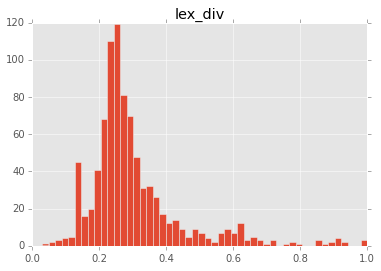

In [38]:
cursor=dbclient.db_restT.diversity.aggregate([
    {'$project': {
            '_id': 0,
            'name': '$name',
            'lex_div': '$lexical_diversity'}}])
lex_div=DataFrame(list(cursor))
lex_div.hist('lex_div', bins=50)

<a name='toc_2.3'></a>2.3: Track unfollows
--
Write a python program to create a db called db_followers that stores all the followers for all the users that you find in task 2.1. Then, write a program to find the un-followed friends after a week for the top 10 users( users that have the highest number of followers in task 2.1) since the time that you extracted the tweets. In other words, you need to look for the people following the top 10 users at time X (the time that you extracted the tweets) and then look at the people following the same top 10 users at a later time Y (one-week after X) to see who stopped following the top 10 users.

First, make a db/table of top RT'ed users in which to store follower stats

In [39]:
dbclient.drop_database('db_followers')
rows=[]
for row in dbclient.db_tweets.top_retweets.aggregate([
        {'$group': {
                '_id': '$user.id',
                'name': {'$first': '$user.screen_name'},
                'initial_count': {'$first': '$user.followers_count'}}}]):
    rows.append(dict(row))
dbclient.db_followers.top_rt_followers.insert_many(rows)
dbclient.db_followers.top_rt_followers.create_index('initial_count')

u'initial_count_1'

Now fetch the list of followers for the top 10 by followers.
The API rate limit is 15 calls per hour, and each call can return 5000 followers.  While this may compromise the efficacy of the assignment there are over 19 million followers for these users, I will only fetch the first 10k followers to avoid spending 11 days fetching all the followers (particularly since they would have changed in that time).

In [56]:
# make this a function to be able to call it at start and end
def get_followers(tag):
    follower_limit=10000
    users=[]
    for row in dbclient.db_followers.top_rt_followers.find(
        {},sort=[('initial_count', -1)]).limit(10):
        users.append(row['_id'])
    for (num,user) in enumerate(users):
        print("Processing user", num)
        cursor=tweepy.Cursor(
                        api.followers_ids,
                        count=5000,
                        user_id=user).items(follower_limit)
        while True:
            try: 
                followers=[]
                for follower in cursor:
                    followers.append(follower)
                dbclient.db_followers.top_rt_followers.update_one(
                    {'_id': user},
                    {'$set': { tag+'_followers': followers,
                               tag+'_date': datetime.datetime.now()}},
                    upsert=True)
                break
            except tweepy.TweepError, e:
                s=""
                if e.response and e.response.status:
                    s=e.response.status
                print(e, s)
                if s == 104:
                    continue
                break
            except Exception, e:
                print(e)
                break

In [57]:
get_followers('initial')

Processing user 0
Rate limit reached. Sleeping for: 690
Failed to send request: ('Connection aborted.', error(104, 'Connection reset by peer')) 
Processing user 1
Processing user 2
Processing user 3
Processing user 4
Processing user 5
Processing user 6
Processing user 7
Processing user 8
Rate limit reached. Sleeping for: 897
Failed to send request: ('Connection aborted.', error(104, 'Connection reset by peer')) 
Processing user 9


After a week, run the second phase

In [129]:
get_followers('final')


Processing user 0
Processing user 1
Processing user 2
Processing user 3
Processing user 4
Processing user 5
Processing user 6
Processing user 7
Rate limit reached. Sleeping for: 897
Failed to send request: ('Connection aborted.', error(104, 'Connection reset by peer')) 
Processing user 8
Processing user 9


And report the results

In [162]:
for row in dbclient.db_followers.top_rt_followers.find(
        {},sort=[('initial_count', -1)]).limit(10):
    init=set(row['initial_followers'])
    final=set(row['final_followers'])
    print("{0}:\n\tlost {1}\tgained {2}\tdelta {3}\n\tin {4}".format( 
          row['name'],
          len(init-final), len(final-init),
          row['final_count']-row['initial_count'],
          row['final_date']-row['initial_date'],
        ))

ciara:
	lost 0	gained 0	delta 1902
	in 10 days, 2:21:58.343000
ToniKroos:
	lost 0	gained 0	delta 1496
	in 10 days, 2:21:58.420000
StephenCurry30:
	lost 0	gained 0	delta 986
	in 10 days, 2:21:58.441000
BIGMONEYMIKE6:
	lost 0	gained 0	delta -375
	in 10 days, 2:21:58.459000
rickyrubio9:
	lost 0	gained 0	delta -4199
	in 10 days, 2:21:58.517000
warriors:
	lost 0	gained 0	delta -1731
	in 10 days, 2:21:58.536000
WeLoveRobDyrdek:
	lost 0	gained 0	delta -4976
	in 10 days, 2:21:58.844000
SFGiants:
	lost 0	gained 0	delta 1377
	in 10 days, 2:21:58.914000
the_ironsheik:
	lost 0	gained 0	delta -4895
	in 10 days, 2:21:58.932000
Whataburger:
	lost 0	gained 0	delta 778
	in 10 days, 2:21:58.952000


Despite changes to the follower counts, there were no IDs in the final set not in the initial one.  As I had feared, the sample size of 10000 followers was not enough to capture the changed follower IDs.

<a name='toc_2.4'></a>2.4: Sentiment analysis
--
(Bonus task) Write a python program and use NLTK to analyze the top 30 retweets of task 2.1 as positive or negative (sentiment analysis). This is the bonus part of the assignment.

In [197]:
# Fetched a corpus of classified tweets from
# http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/
# -- Note: Omitted from git push due to size.
# Incorporating feature ideas described in Kiritchenko et al, Sentiment Analysis of Short Informal Texts
# stemmed tokens, POS-tagged tokens, final hashtags,n-grams
# As classifier use random forest from scikit-learn

<a name='toc_3'></a>3: Storing and Retrieving Task
===
<a name='toc_3.1'></a>3.1: Backup & Restore
---
Write a python program to create and store the backups of both db_tweets and db_restT to S3. It also should have a capability of loading the backups if necessary.

To backup a database, call `mongodump` to dump the database BSON files, compress them, and copy the archive to a user-provided S3 bucket.

For this assignment, I am using s3 bucket `nkrishna-mids205-hw3`.  I think I forgot to grant ListBucket privs last time, so I have added them to this bucket as well as GetObject.

In [188]:
import subprocess
import json
from boto.s3.key import Key

def dump_db(s3bucket, dbname):
    dumpdir='dump/'+dbname
    subprocess.call(['rm','-rf', dumpdir])
    print("Dumping database", dbname)
    subprocess.call(['mongodump', '--db', dbname])
    zipfile=dbname+'.zip'
    print("Compressing database dump")
    subprocess.call(['zip', '-r', zipfile, dumpdir])
    key=Key(bucket, zipfile)
    print('Uploading database dump to s3://{0}/{1}'.format(
        bucket.name, zipfile))
    key.set_contents_from_filename(zipfile)
    subprocess.call(['rm', '-rf', dumpdir, zipfile])

In [189]:
from boto.s3.connection import S3Connection
s3creds=Credentials(os.path.expanduser('~/.aws/credentials'))
conn=S3Connection(s3creds.default_aws_access_key_id,
    s3creds.default_aws_secret_access_key)
bucket_name='nkrishna-mids205-hw3'
bucket=conn.lookup(bucket_name)
if not bucket:
    bucket=conn.create_bucket(bucket_name)
dump_db(bucket, 'db_tweets')
dump_db(bucket, 'db_restT')

Dumping database db_tweets
Compressing database dump
Uploading database dump to s3://nkrishna-mids205-hw3/db_tweets.zip
Dumping database db_restT
Compressing database dump
Uploading database dump to s3://nkrishna-mids205-hw3/db_restT.zip


Restoring will simply invert the steps: fetch the zipped BSON dumps, extract them, and call `mongorestore`

In [193]:
def restore_db(s3bucket, dbname):
    dumpdir='dump/'+dbname
    subprocess.call(['rm','-rf', dumpdir])
    zipfile=dbname+'.zip'
    key=Key(bucket, zipfile)
    print('Downloading database dump from s3://{0}/{1}'.format(
        bucket.name, zipfile))
    key.get_contents_to_filename(zipfile)
    print("Decompressing database dump")
    subprocess.call(['unzip', zipfile])
    print("Restoring database", dbname)
    subprocess.call(['mongorestore', dumpdir])
    subprocess.call(['rm', '-rf', dumpdir, zipfile])

In [194]:
dbclient.drop_database('db_tweets')
restore_db(bucket, 'db_tweets')
dbclient.drop_database('db_restT')
restore_db(bucket, 'db_restT')

Decompressing database dump
Restoring database db_tweets
Decompressing database dump
Restoring database db_restT


Verify that the older sanity check still works.

In [195]:
print(dbclient.db_restT.users.count(), "total users")
print(dbclient.db_restT.user_tweets.count(), "total tweets")
print(len(list(
            dbclient.db_restT.user_tweets.aggregate(
                [{'$group': {'_id': '$user'}}]))), "users with tweets")

6542 total users
641016 total tweets
870 users with tweets
